#### Importaciones

In [ ]:
import pandas as pd
import missingno as msno
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

#### EDA

In [2]:
df_flights = pd.read_csv('flights.csv',low_memory=False)

In [3]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

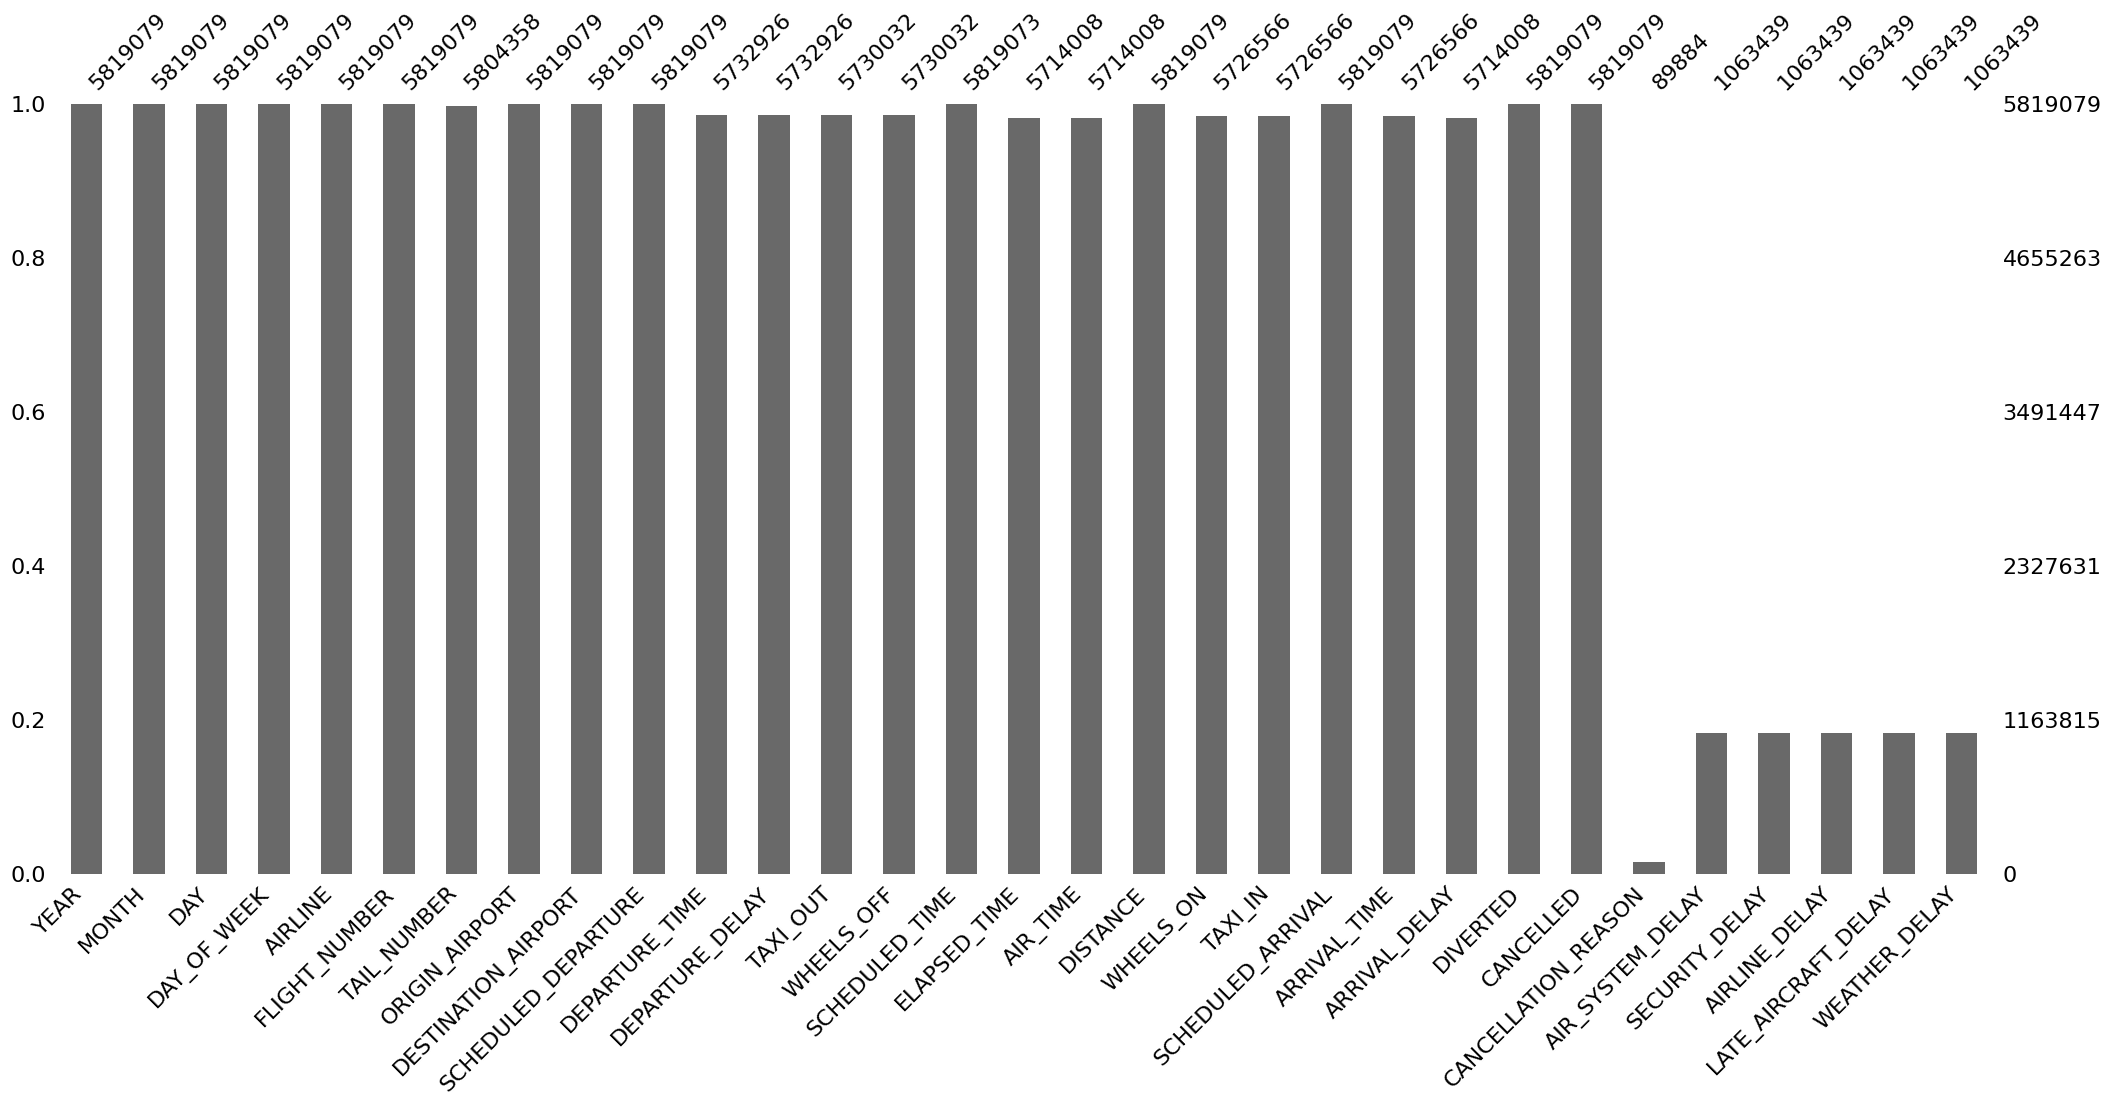

In [4]:
msno.bar(df_flights)
plt.show()

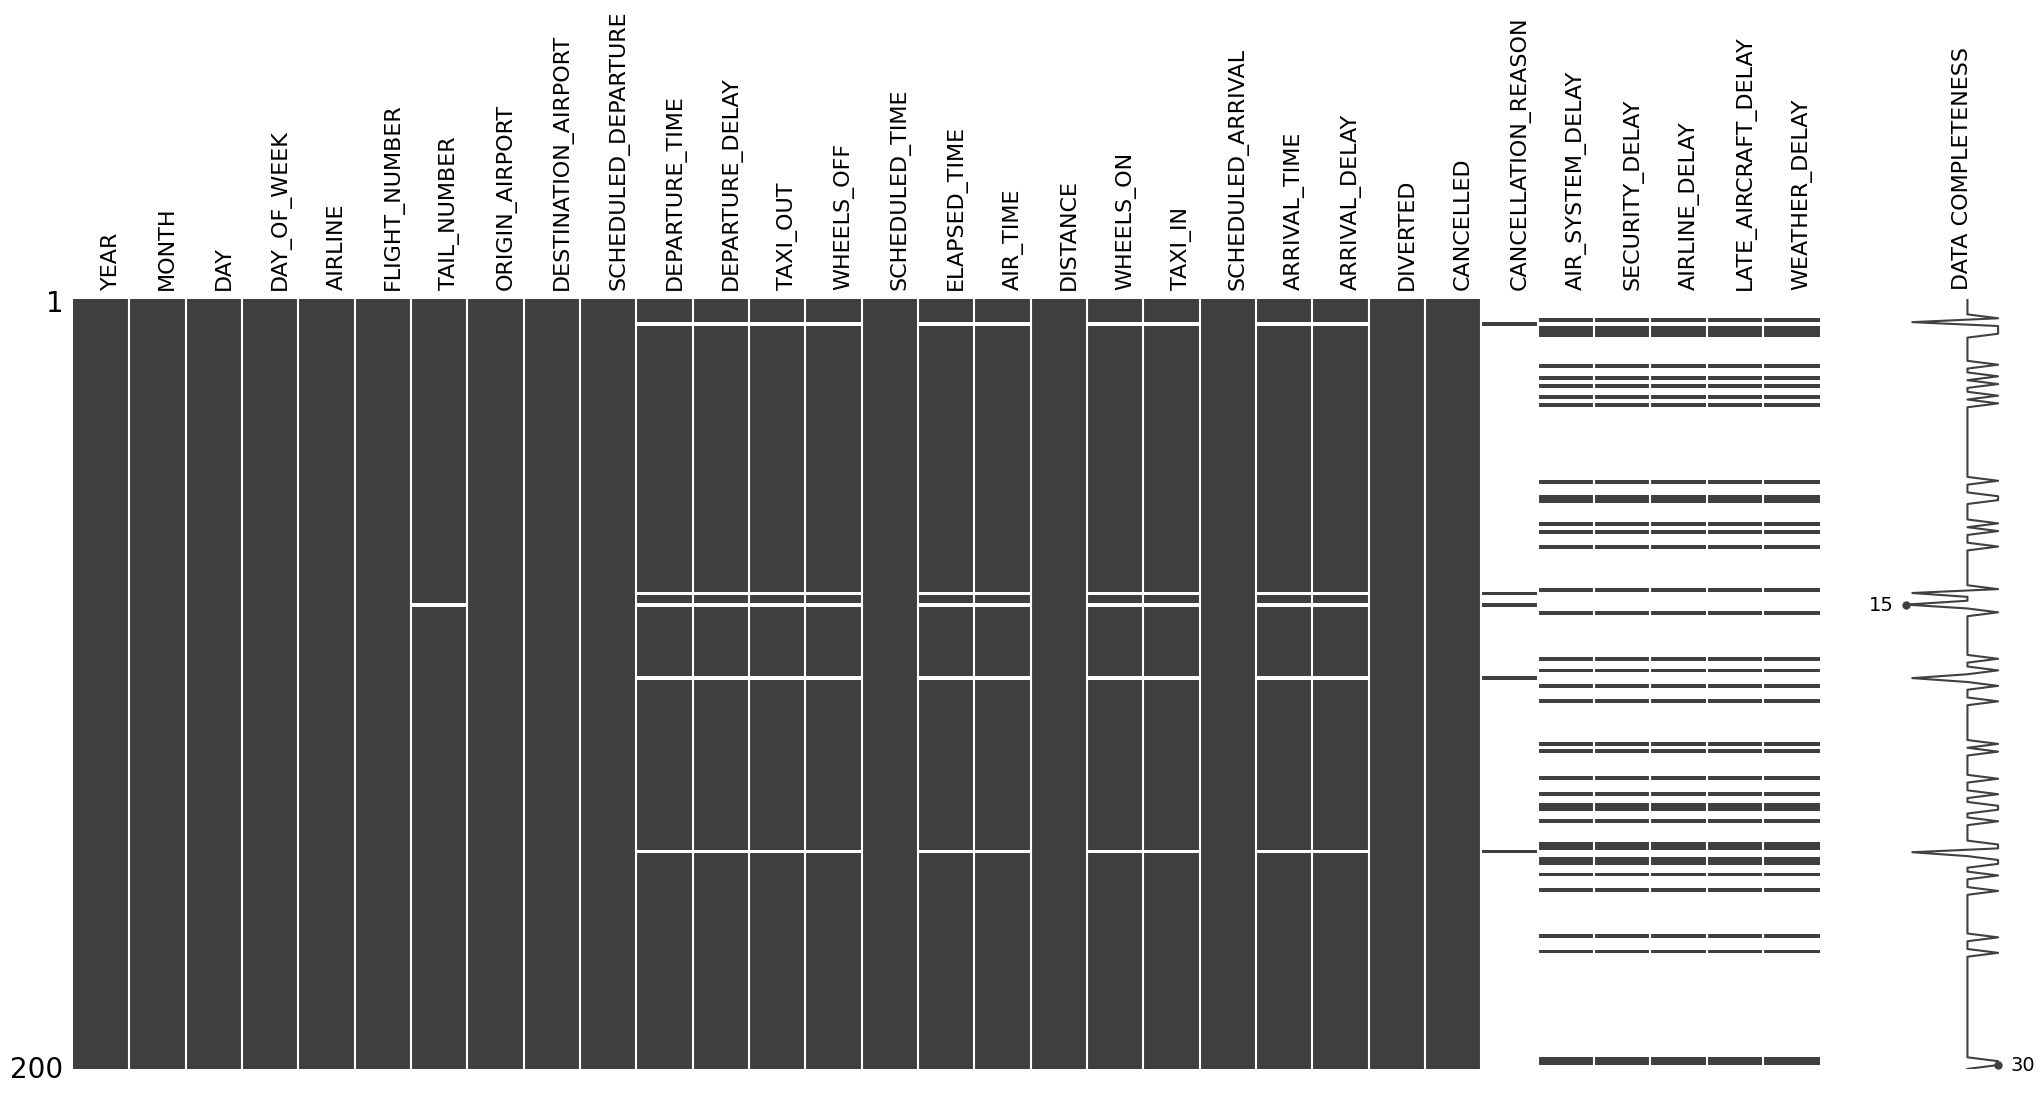

In [5]:
msno.matrix(df_flights.sample(200), labels = True, label_rotation = 90)
plt.show()

In [6]:
df_flights.CANCELLED.value_counts()

CANCELLED
0    5729195
1      89884
Name: count, dtype: int64

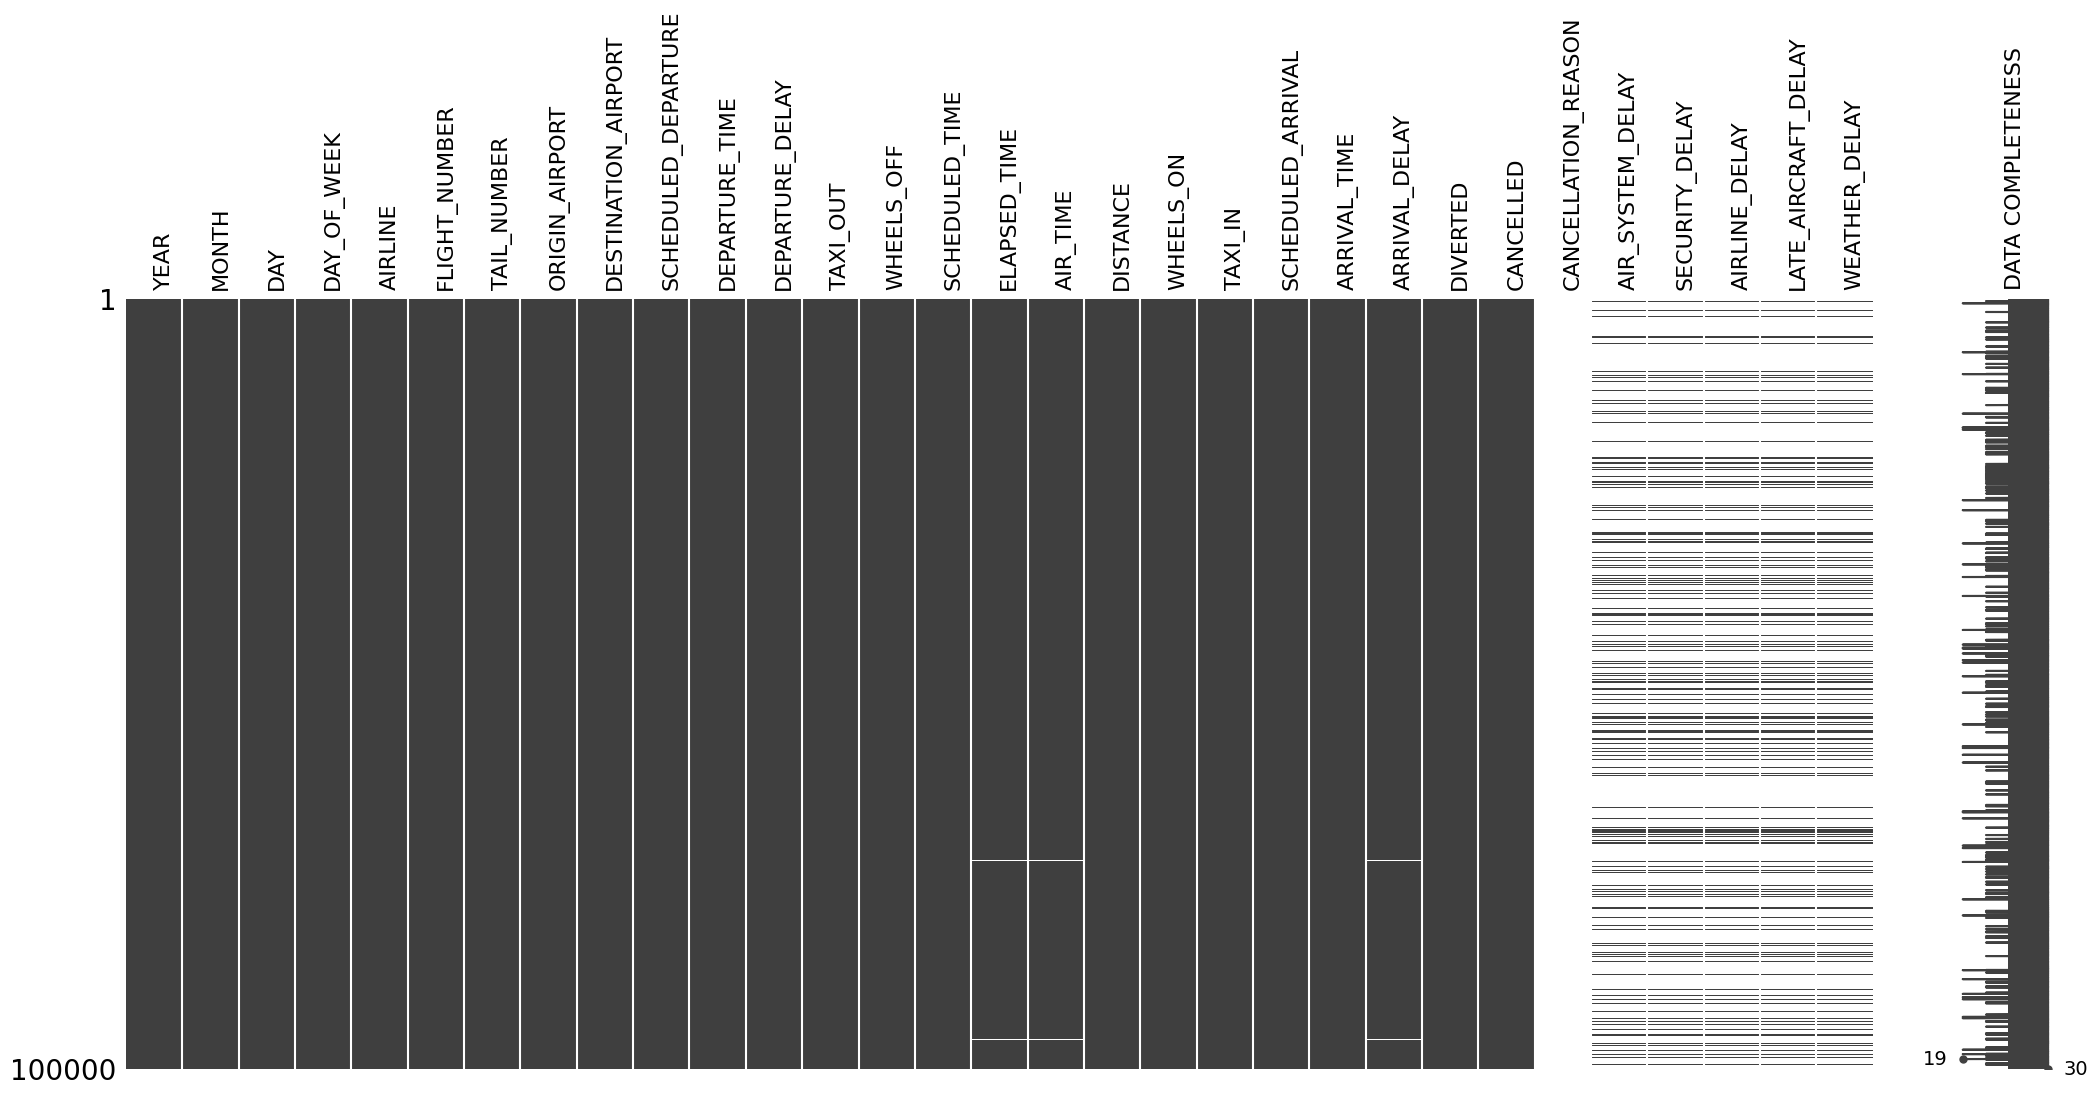

In [7]:
cancelados = df_flights.CANCELLED == 1
msno.matrix(df_flights[~cancelados].sample(100000), labels = True, label_rotation = 90)
plt.show()

In [8]:
#Se eliminan los registros de los vuelos cancelados y luego esa columna
df_sin_cancel = df_flights[~cancelados].copy() 
df_sin_cancel.drop(columns=["CANCELLED"],inplace=True)

In [9]:
#Se eliminan columnas que no aportan informacion relevante
df_sin_cancel.drop(columns=["TAIL_NUMBER", "FLIGHT_NUMBER","CANCELLATION_REASON"], inplace=True)


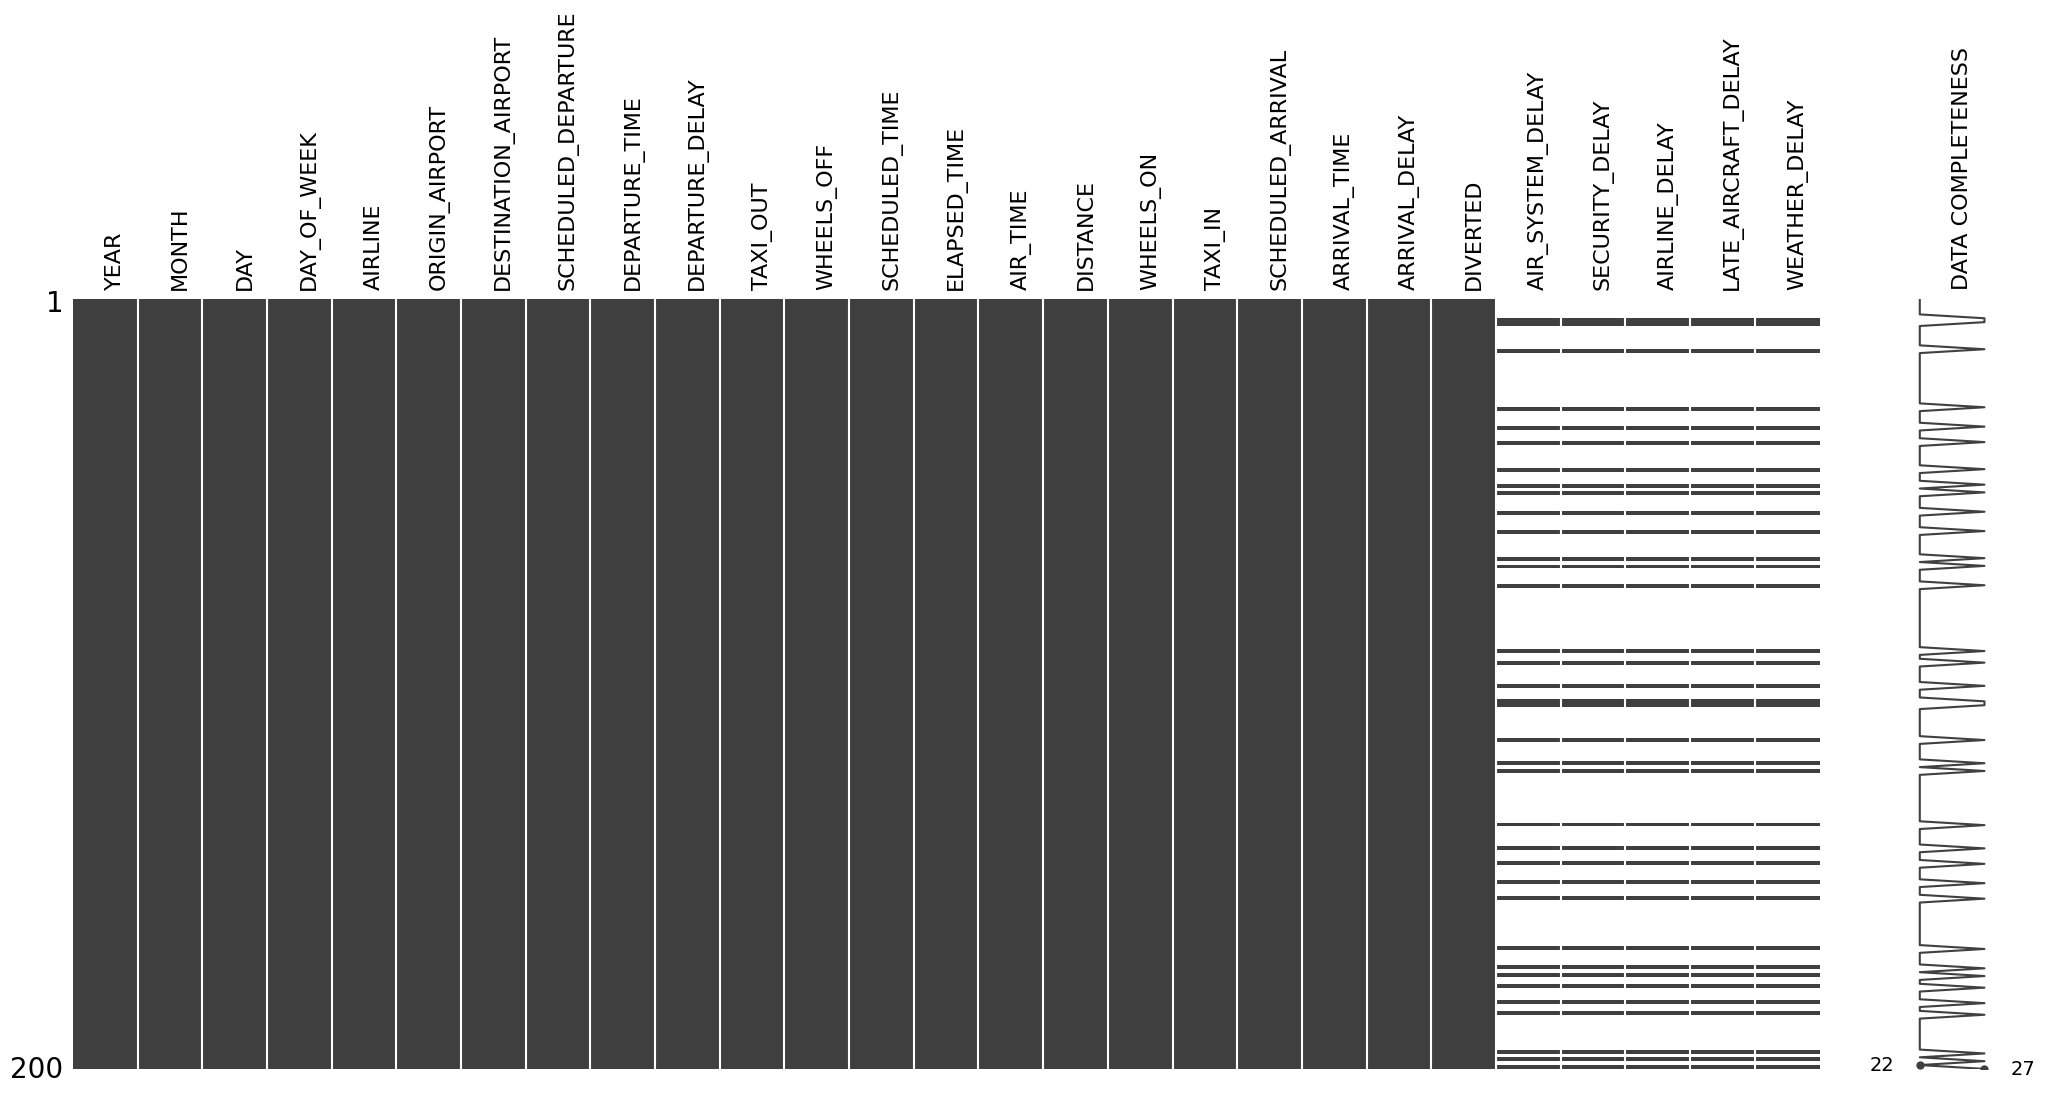

In [10]:
msno.matrix(df_sin_cancel.sample(200), labels = True, label_rotation = 90)
plt.show()

In [11]:
df_sin_cancel.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               1
ELAPSED_TIME             15187
AIR_TIME                 15187
DISTANCE                     0
WHEELS_ON                 2629
TAXI_IN                   2629
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME              2629
ARRIVAL_DELAY            15187
DIVERTED                     0
AIR_SYSTEM_DELAY       4665756
SECURITY_DELAY         4665756
AIRLINE_DELAY          4665756
LATE_AIRCRAFT_DELAY    4665756
WEATHER_DELAY          4665756
dtype: int64

In [12]:
# nan Delay cambio por 0
df_sin_cancel['AIR_SYSTEM_DELAY'] = df_sin_cancel['AIR_SYSTEM_DELAY'].fillna(0)
df_sin_cancel['SECURITY_DELAY'] = df_sin_cancel['SECURITY_DELAY'].fillna(0)
df_sin_cancel['AIRLINE_DELAY'] = df_sin_cancel['AIRLINE_DELAY'].fillna(0)
df_sin_cancel['LATE_AIRCRAFT_DELAY'] = df_sin_cancel['LATE_AIRCRAFT_DELAY'].fillna(0)
df_sin_cancel['WEATHER_DELAY'] = df_sin_cancel['WEATHER_DELAY'].fillna(0)

In [13]:
df_sin_cancel.dropna(inplace=True)

In [14]:
df_sin_cancel.isna().any()

YEAR                   False
MONTH                  False
DAY                    False
DAY_OF_WEEK            False
AIRLINE                False
ORIGIN_AIRPORT         False
DESTINATION_AIRPORT    False
SCHEDULED_DEPARTURE    False
DEPARTURE_TIME         False
DEPARTURE_DELAY        False
TAXI_OUT               False
WHEELS_OFF             False
SCHEDULED_TIME         False
ELAPSED_TIME           False
AIR_TIME               False
DISTANCE               False
WHEELS_ON              False
TAXI_IN                False
SCHEDULED_ARRIVAL      False
ARRIVAL_TIME           False
ARRIVAL_DELAY          False
DIVERTED               False
AIR_SYSTEM_DELAY       False
SECURITY_DELAY         False
AIRLINE_DELAY          False
LATE_AIRCRAFT_DELAY    False
WEATHER_DELAY          False
dtype: bool

In [15]:
df = df_sin_cancel.copy()

In [16]:
df.shape

(5714008, 27)

#### Codificacion de variables categoricas

In [17]:
# Detectar columnas categóricas
cat_cols = df.select_dtypes(include=["object"]).columns

# Aplicar Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

#### Preparacion y entrenamiento del modelo

In [18]:
# Separacion de features y target
X = df.drop(columns=['ARRIVAL_DELAY'])
y = df['ARRIVAL_DELAY']

In [19]:
#Train/test spit
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.3, random_state = 42
)

In [20]:
# Crear DMatrix
dtrain = xgb.DMatrix(X_train,label=y_train)
dval = xgb.DMatrix(X_val,label=y_val)

In [21]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "nthread": 4
}

evallist = [(dval, 'eval'), (dtrain, 'train')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evallist,
    early_stopping_rounds=10,
    verbose_eval=10
)


[0]	eval-rmse:37.50663	train-rmse:37.51855
[10]	eval-rmse:16.83121	train-rmse:16.81677
[20]	eval-rmse:10.58270	train-rmse:10.53968
[30]	eval-rmse:8.94497	train-rmse:8.87495
[40]	eval-rmse:8.09748	train-rmse:7.99925
[50]	eval-rmse:7.59867	train-rmse:7.48403
[60]	eval-rmse:7.17041	train-rmse:7.04406
[70]	eval-rmse:6.71585	train-rmse:6.57102
[80]	eval-rmse:6.33737	train-rmse:6.17178
[90]	eval-rmse:5.92412	train-rmse:5.73825
[100]	eval-rmse:5.65211	train-rmse:5.44510
[110]	eval-rmse:5.44426	train-rmse:5.21526
[120]	eval-rmse:5.25549	train-rmse:5.00597
[130]	eval-rmse:5.06062	train-rmse:4.78085
[140]	eval-rmse:4.88109	train-rmse:4.58490
[150]	eval-rmse:4.74815	train-rmse:4.41737
[160]	eval-rmse:4.57769	train-rmse:4.22352
[170]	eval-rmse:4.43373	train-rmse:4.05536
[180]	eval-rmse:4.32363	train-rmse:3.91805
[190]	eval-rmse:4.13905	train-rmse:3.69441
[200]	eval-rmse:4.05287	train-rmse:3.57265
[210]	eval-rmse:3.96281	train-rmse:3.45057
[220]	eval-rmse:3.89957	train-rmse:3.36642
[230]	eval-rmse:

In [ ]:
#Evaluacion del modelo
y_pred = model.predict(dval)

rmse = root_mean_squared_error(y_val, y_pred) # mean_squared deprecated
mae = mean_absolute_error(y_val, y_pred)

print(f"RMSE: {rmse:.2f} minutos")
print(f"MAE: {mae:.2f} minutos")

RMSE: 2.73 minutos
MAE: 0.96 minutos


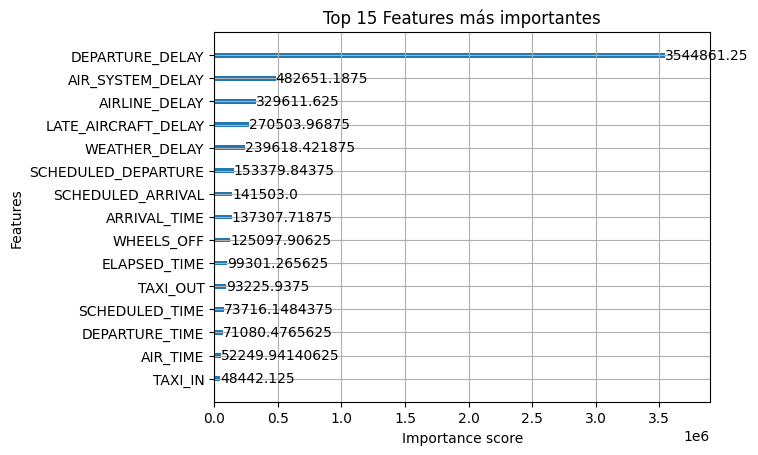

In [ ]:
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Features más importantes")
plt.show()

In [33]:
# Guardado del modelo
model.save_model("modelo_retrasos.model")



C:\Users\Carlos\AppData\Local\Temp\ipykernel_15344\2179494033.py:2: UserWarning: [22:11:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  model.save_model("modelo_retrasos.model")
